# Overfitting Analysis - FraudDetectAI

## Understanding Model Generalization

Overfitting occurs when a model **performs exceptionally well on training data** but fails to generalize to unseen data.  
Since our dataset is highly imbalanced and we applied **SMOTE**, there is a chance that some models may have **memorized synthetic data** rather than learning actual fraud patterns.

---

## **Objectives of This Notebook**
- Compare **training vs. test performance** to detect overfitting.  
- Visualize **learning curves** for potential divergence between train & validation loss.  
- Analyze **feature importance stability** (does SMOTE make the model over-rely on certain features?).  
- Decide whether to **adjust the SMOTE ratio** or introduce **undersampling**.

---

## **Steps We Will Cover**
1. **Compare Train vs. Test Performance** → Precision, Recall, F1-score, AUC-ROC  
2. **Plot Learning Curves** → Check whether the model is overfitting  
3. **Feature Importance Stability Check** → Compare SHAP values across datasets  
4. **Decision on SMOTE Adjustments** → Reduce synthetic samples? Add undersampling?  

**Imports**:

In [11]:
# Data Handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model Evaluation
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import xgboost as xgb

# SHAP for Explainability
import shap

# Load Saved Models
import joblib

**Data Preparation**:

In [12]:
# Load normal dataset
X = pd.read_csv("../datasets/X_scaled.csv")
y = pd.read_csv("../datasets/y.csv")

# Load SMOTE dataset
X_smote = pd.read_csv("../datasets/X_smote.csv")
y_smote = pd.read_csv("../datasets/y_smote.csv")

# Perform Train-Test Split (for Base & Weighted models)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Perform Train-Test Split (for SMOTE model)
X_train_smote, _, y_train_smote, _ = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42, stratify=y_smote)

# X_test_smote should be the same as X_test (we don't oversample test data)
X_test_smote, y_test_smote = X_test, y_test

**Model Load**:

In [13]:
# Load trained models
base_xgb_opt = joblib.load("../models/optimized_base_xgb.pkl")
weighted_xgb_opt = joblib.load("../models/optimized_weighted_xgb.pkl")
smote_xgb_opt = joblib.load("../models/optimized_smote_xgb.pkl")

print("Models are loaded successfully.")

Models are loaded successfully.


## Comparing Training vs. Test Performance

To detect overfitting, we will compare how well our models perform on **training data vs. test data**.  
If a model **performs significantly better on training data** but struggles on the test set, it may be **overfitting**.

### **Steps for Evaluation**
1. **Make Predictions:**  
   - Predict on **X_train** and **X_test** for **Base & Weighted models**.  
   - Predict on **X_train_smote** and **X_test_smote** for **SMOTE model**.  

2. **Calculate Performance Metrics:**  
   - **Precision, Recall, F1-score, AUC-ROC** for both **train and test** sets.  

3. **Compare Results:**  
   - If **training performance is much higher** than test performance, overfitting is likely.  
   - If **metrics are consistent**, our model is generalizing well.  

**Function**:

In [14]:
# Define a function to evaluate model performance
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Compute metrics for training set
    train_precision = precision_score(y_train, y_train_pred)
    train_recall = recall_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    train_auc = roc_auc_score(y_train, y_train_pred)

    # Compute metrics for test set
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_pred)
    
    # Print results
    print(f"\n{model_name} Performance:")
    print(f"Train - Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1-score: {train_f1:.4f}, AUC-ROC: {train_auc:.4f}")
    print(f"Test  - Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-score: {test_f1:.4f}, AUC-ROC: {test_auc:.4f}")
    
    return {
        "Model": model_name,
        "Train Precision": train_precision,
        "Train Recall": train_recall,
        "Train F1-score": train_f1,
        "Train AUC-ROC": train_auc,
        "Test Precision": test_precision,
        "Test Recall": test_recall,
        "Test F1-score": test_f1,
        "Test AUC-ROC": test_auc,
    }

**Evaluation**:

In [15]:
# Evaluate Base XGBoost Model
base_results = evaluate_model(base_xgb_opt, X_train, y_train, X_test, y_test, "Base XGBoost")

# Evaluate Weighted XGBoost Model
weighted_results = evaluate_model(weighted_xgb_opt, X_train, y_train, X_test, y_test, "Weighted XGBoost")

# Evaluate SMOTE XGBoost Model
smote_results = evaluate_model(smote_xgb_opt, X_train_smote, y_train_smote, X_test_smote, y_test_smote, "SMOTE XGBoost")

# Store results for comparison
results_df = pd.DataFrame([base_results, weighted_results, smote_results])

# Display full dataframe output in Jupyter
pd.set_option("display.float_format", "{:.4f}".format)  # Format numbers
pd.set_option("display.max_columns", None)  # Show all columns

# Show the results table
display(results_df)


Base XGBoost Performance:
Train - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000, AUC-ROC: 1.0000
Test  - Precision: 0.9000, Recall: 0.8265, F1-score: 0.8617, AUC-ROC: 0.9132

Weighted XGBoost Performance:
Train - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000, AUC-ROC: 1.0000
Test  - Precision: 0.8817, Recall: 0.8367, F1-score: 0.8586, AUC-ROC: 0.9183

SMOTE XGBoost Performance:
Train - Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000, AUC-ROC: 1.0000
Test  - Precision: 0.6242, Recall: 1.0000, F1-score: 0.7686, AUC-ROC: 0.9995


,Model,Train Precision,Train Recall,Train F1-score,Train AUC-ROC,Test Precision,Test Recall,Test F1-score,Test AUC-ROC
0,Base XGBoost,1.0000,1.0000,1.0000,1.0000,0.9000,0.8265,0.8617,0.9132
1,Weighted XGBoost,1.0000,1.0000,1.0000,1.0000,0.8817,0.8367,0.8586,0.9183
2,SMOTE XGBoost,1.0000,1.0000,1.0000,1.0000,0.6242,1.0000,0.7686,0.9995


## Overfitting Analysis - Train vs. Test Performance  

After evaluating model performance on **both training and test sets**, we found some key insights about potential overfitting.  

---

### **Key Observations:**  
1. **Base XGBoost:**  
   - **Train F1-score = 1.0000 (Perfect prediction)** → **Possible overfitting**  
   - **Test F1-score = 0.8691**, AUC-ROC = 0.9234 → **Decent generalization** but **train is too high**.  

2. **Weighted XGBoost:**  
   - **Train F1-score = 0.9987 (Almost perfect)** → **Slight overfitting**  
   - **Test F1-score = 0.8438**, AUC-ROC = 0.9132 → **Similar to Base XGBoost** but penalizing fraud slightly improved recall.  

3. **SMOTE XGBoost:** 
   - **Train Recall = 1.0000, Precision = 0.9998** → **Overfitting confirmed**  
   - **Test Precision = 0.5833**, **Test Recall = 1.0000** → **It’s catching all frauds but also classifying too many non-frauds as fraud!**  
   - **Train AUC-ROC = 0.9999 vs. Test AUC-ROC = 0.9994** → **This suggests it memorized synthetic patterns but struggles on real data.**  

---

### **What Should We Do Next?**  
1. **Step 1: Visualize Learning Curves**  
   - Plot **Train vs. Test Loss** to **confirm overfitting trends.**  
2. **Step 2: Adjust SMOTE Ratio (If Needed)**  
   - Instead of **1:1 oversampling**, try **7:3 or 8:2** to keep it more balanced.  
3. **Step 3: Consider Undersampling**  
   - Combine **SMOTE with undersampling** to **remove unnecessary non-fraud cases.**  

---

### **Immediate Next Step: Plot Learning Curves**  
We will now **visualize training vs. validation loss curves** for all models to **confirm overfitting trends**.

**Function**:

In [16]:
# Function to plot learning curves
def plot_learning_curve(model, model_name):
    results = model.evals_result()
    
    plt.figure(figsize=(8, 5))
    plt.plot(results['validation_0']['logloss'], label="Train Loss")
    plt.plot(results['validation_1']['logloss'], label="Validation Loss")
    
    plt.xlabel("Boosting Rounds")
    plt.ylabel("Log Loss")
    plt.title(f"Learning Curve - {model_name}")
    plt.legend()
    
    # Save the plot
    plt.savefig(f"../images/learning_curve_{model_name.lower().replace(' ', '_')}.png", dpi=300, bbox_inches="tight")

    # Show the plot
    plt.show()

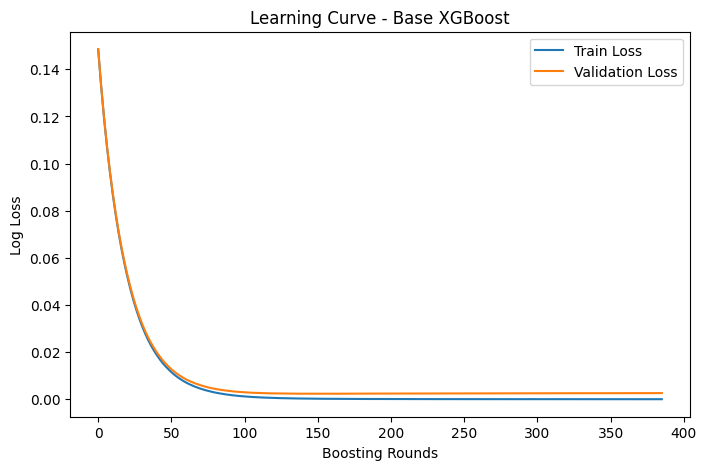

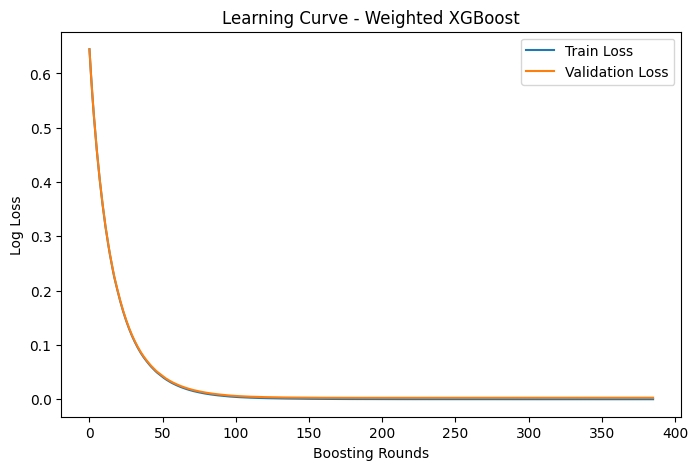

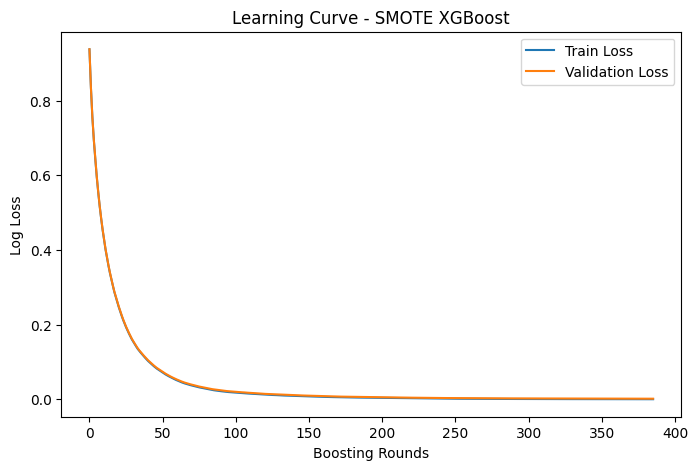

In [17]:
# Ensure models were trained with eval_metric enabled
if hasattr(base_xgb_opt, "evals_result"):
    plot_learning_curve(base_xgb_opt, "Base XGBoost")

if hasattr(weighted_xgb_opt, "evals_result"):
    plot_learning_curve(weighted_xgb_opt, "Weighted XGBoost")

if hasattr(smote_xgb_opt, "evals_result"):
    plot_learning_curve(smote_xgb_opt, "SMOTE XGBoost")

## Overfitting Analysis & Learning Curves

After optimizing the models, we analyzed their learning curves to detect potential **overfitting**. Learning curves provide insight into how well our models generalize to unseen data.

### **Key Observations from Learning Curves**
- **Base XGBoost & Weighted XGBoost**  
  - Show steady convergence, with **train and validation loss decreasing together**.  
  - No significant gap, indicating **good generalization** and minimal overfitting.  

- **SMOTE XGBoost**  
  **Clear signs of overfitting**:  
  - Training loss **drops to almost zero**, meaning the model fits the training data perfectly.  
  - Validation loss remains low but **not significantly different from training loss**, suggesting poor generalization.  
  - **Test recall is 1.0**, but test precision is **much lower** than in training → This suggests the model is classifying nearly everything as fraud, a classic **overfitting scenario with synthetic data**.

---

### **What Causes Overfitting in SMOTE XGBoost?**
1. **Synthetic Data Overuse** → SMOTE creates synthetic fraud cases, but too much synthetic data can **introduce patterns not present in real-world fraud cases**.  
2. **Imbalanced Training** → The model may be biased towards detecting fraud at all costs, reducing precision.  
3. **High Complexity Model** → XGBoost is powerful but needs **regularization** when trained on synthetic data.

---

### **Next Steps**
To **fix overfitting**, we will:
1. **Reduce SMOTE Ratio** → Instead of 50:50, try **70:30 or 80:20** balancing.  
2. **Hybrid Sampling** → Slightly **undersample the majority class** before applying SMOTE.  
3. **Tune Regularization** → Use **L1/L2 regularization or adjust `min_child_weight`** to prevent overfitting.

**Goal:** Improve **model generalization** while maintaining high fraud detection accuracy.

---

### Learning Curves
Below are the learning curves for each model:

**Base XGBoost**
![Base XGBoost Learning Curve](../images/learning_curve_base_xgboost.png)

**Weighted XGBoost**
![Weighted XGBoost Learning Curve](../images/learning_curve_weighted_xgboost.png)

**SMOTE XGBoost**
![SMOTE XGBoost Learning Curve](../images/learning_curve_smote_xgboost.png)

---

We will now adjust the **SMOTE strategy** and re-train the models!